# <center>Modélisation

In [1]:
# Importation des packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
sns.set
pd.set_option('max_columns', 50)

In [2]:
# Importation du dataset
df=pd.read_csv("data/visitor_df.csv", index_col=0)

C:\ProgramData\Anaconda3\envs\py_e_sales\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407580 entries, 0 to 1407579
Data columns (total 19 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   nb_event                           1407580 non-null  int64  
 1   nb_unique_item                     1407580 non-null  int64  
 2   nb_view                            1407580 non-null  int64  
 3   nb_addtocart                       1407580 non-null  int64  
 4   nb_interruptionnav                 1407580 non-null  float64
 5   nb_event_of_most_interesting_item  1407580 non-null  int64  
 6   mean_diftime                       1407580 non-null  float64
 7   std_diftime                        1407580 non-null  float64
 8   full_time_session                  1407580 non-null  float64
 9   mean_time_per_view                 1407580 non-null  float64
 10  mean_time_per_addtocart            1407580 non-null  float64
 11  nb_hclass1              

## Choix du modèle

### Réduction du dataset

L'entrainement des différents modèles selectionnés sur nos données prends un temps très long sur le dataset complet. A cause du caractère deséquilibrés, l'apprentissage n'a pas l'air de se passer correctement. Afin d'eviter ce problème nous avons essayé de reduire le dataset et notamment d'enlever tout les visiteurs n'ayant réalisé qu'une seule opération car nous avons  remarqué que la proportion de visiteur passé une fois sur le site qui a acheté est négligeable. 

In [4]:
pd.crosstab(df['has_bought'], df['nb_event']==1, colnames=['1 seule visite'])

1 seule visite,False,True
has_bought,,
False,394340,1001521
True,11649,70


In [5]:
df[df['nb_event']!=1]['has_bought'].value_counts(normalize=True)

False    0.971307
True     0.028693
Name: has_bought, dtype: float64

L'entrainement sur ce dataset réduit ne débouche pas non plus donc nous avons fais le choix de réduire encore plus le dataset: Nous nous sommes concentré sur les visiteurs ayant réalisé au moins une action addtocart.

In [6]:
"""Environ 71% des clients ont acheté et 28 % n'ont pas acheté. Données déséquilibrées.
la validation croisé et le choix des métriques nous permetterons de le gérer"""
df[df['nb_addtocart']!=0]['has_bought'].value_counts(normalize=True)

False    0.719633
True     0.280367
Name: has_bought, dtype: float64

In [7]:
event = df[df['nb_addtocart']!=0]

### Reduction du nombre de variables

In [65]:
def print_cor_mats(df):

  mats = [df.corr().round(2), df.corr(method='spearman').round(2)]
  cor_types = ['pearson', 'spearman']

  fig, axes = plt.subplots(2,1, figsize=(30,50))

  for ax, mat, c_type in zip(axes.flat, mats, cor_types):
    sns.heatmap(mat, annot=True, cmap='coolwarm', ax=ax)
    ax.set_title(f'Correlation Matrix - {c_type} coefficients', fontsize=30)
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, fontsize=22, rotation=45, ha='right')
    labels = ax.get_yticklabels()
    ax.set_yticklabels(labels, fontsize=22)

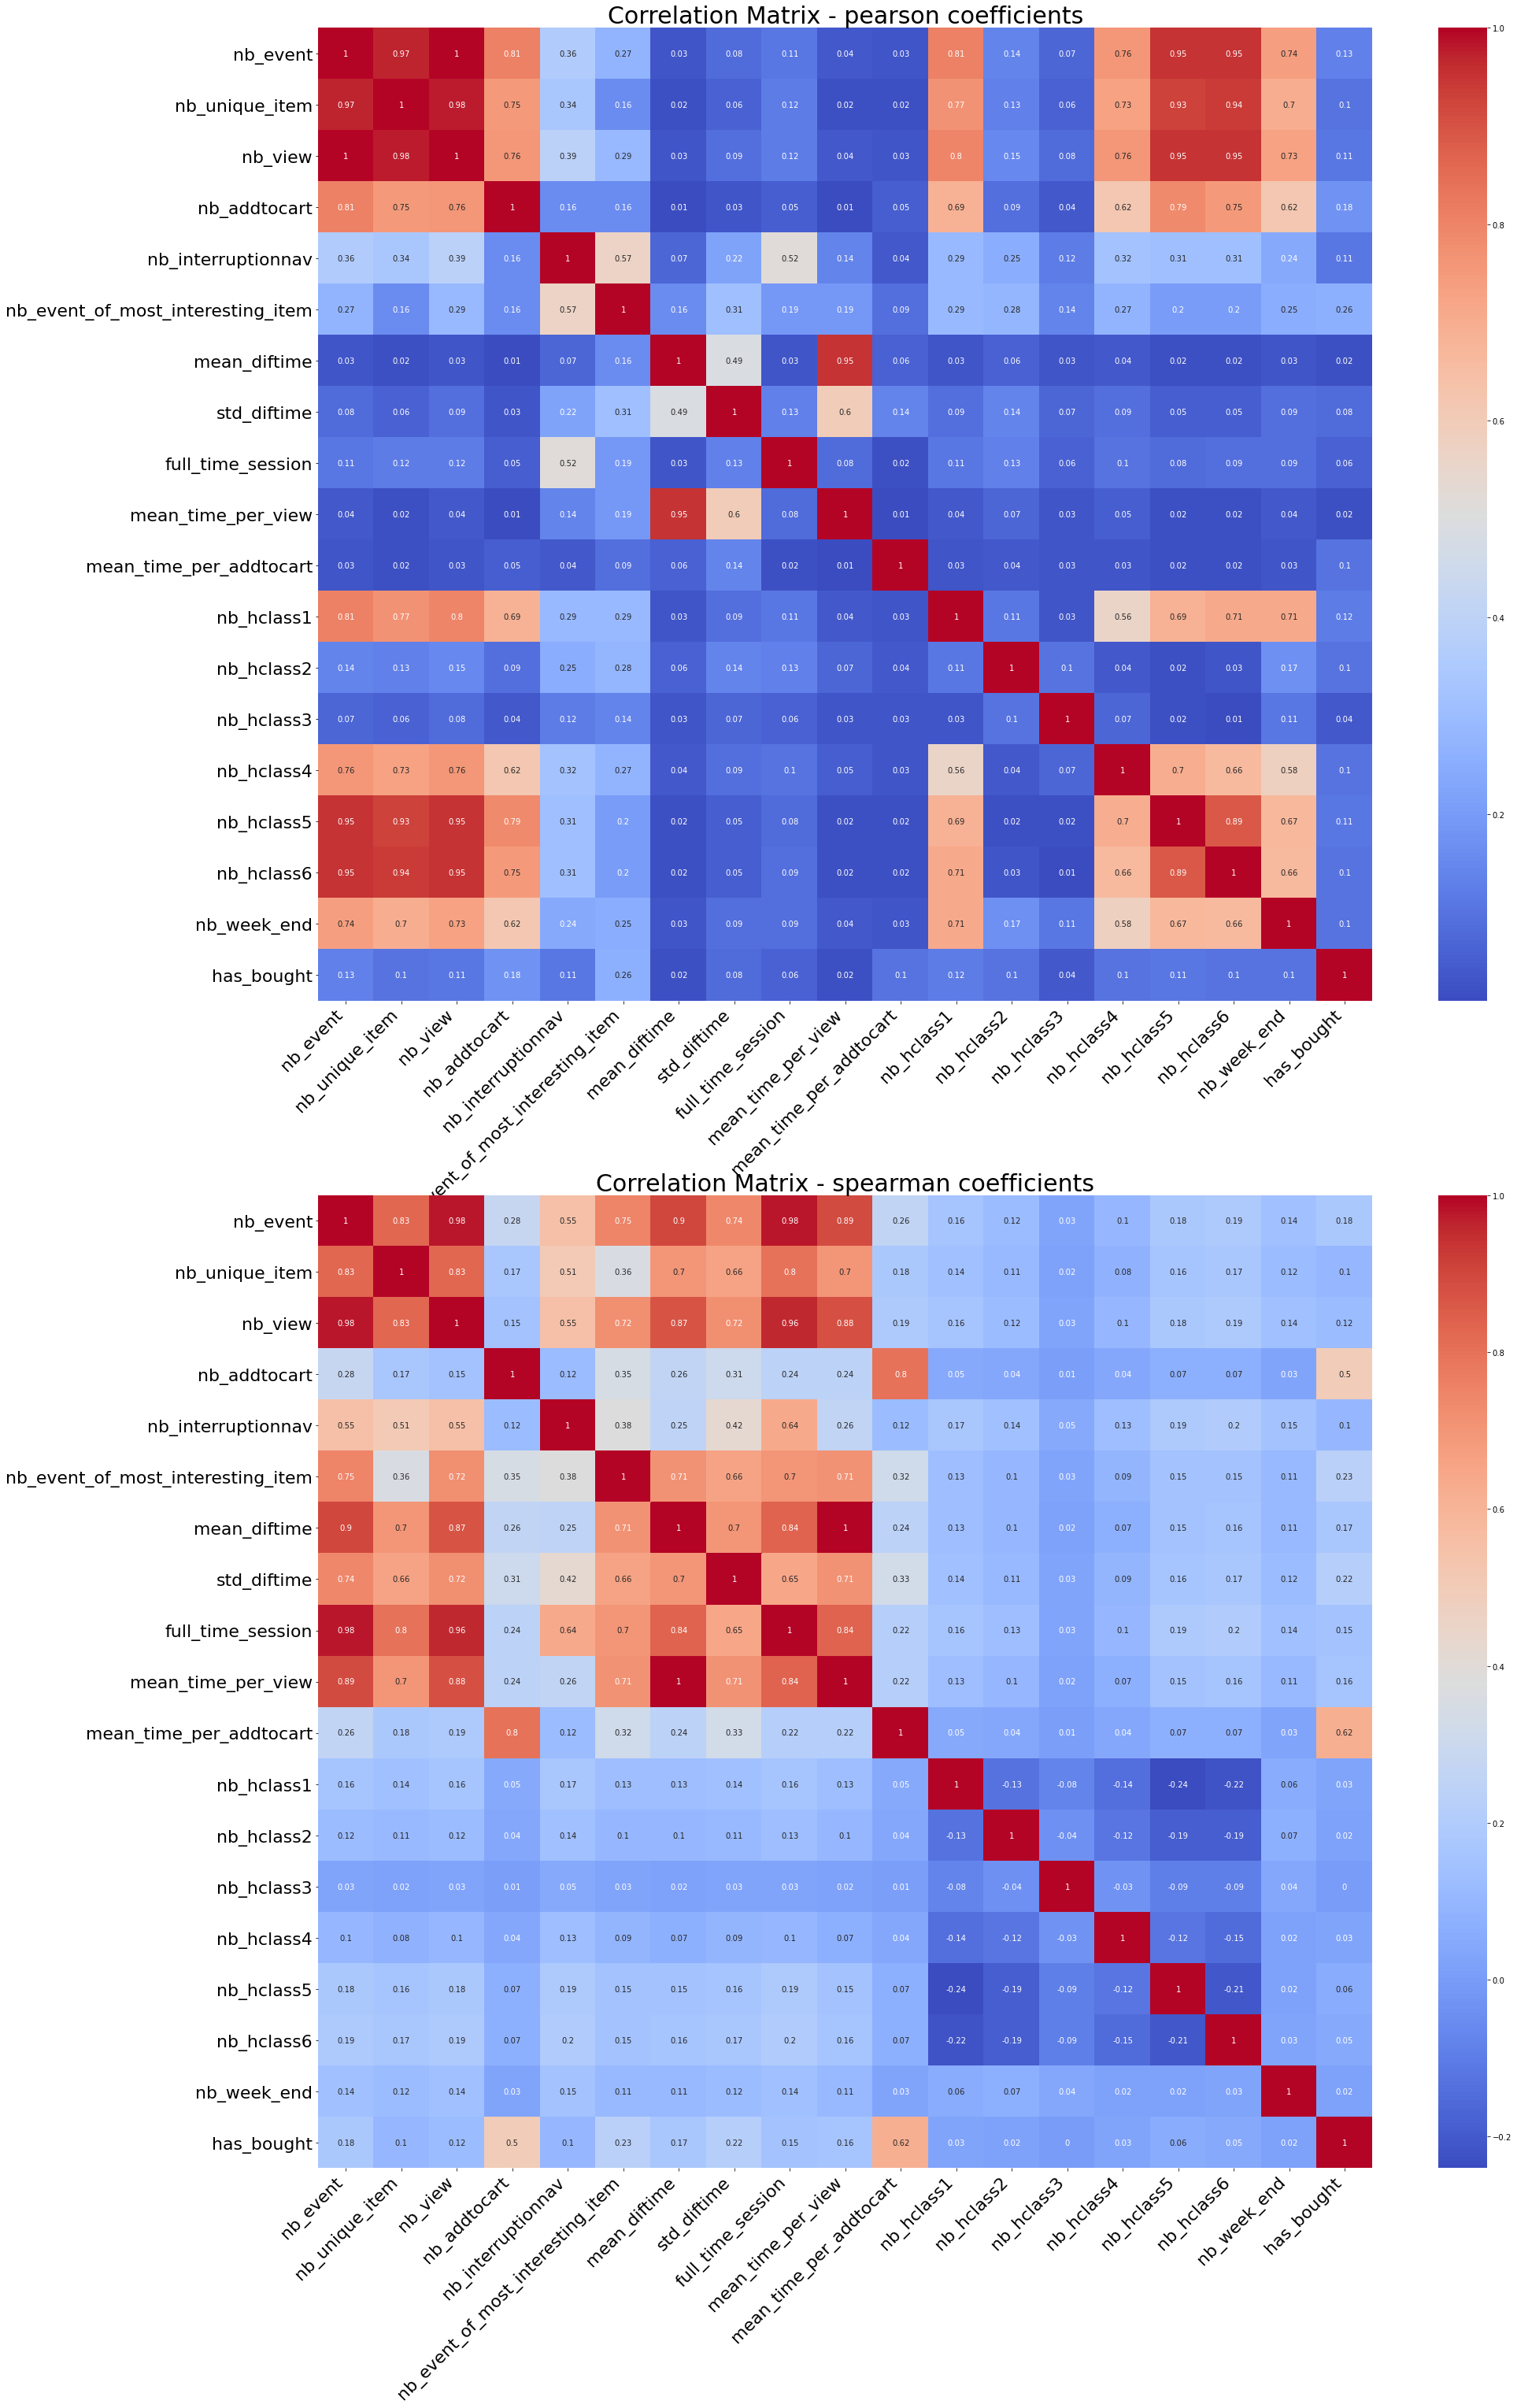

In [67]:
print_cor_mats(df)

Parmis les variables, celles qui possèdent le plus de corrélation avec la variable cible sont: 'nb_addtocart' et 'mean_time_per_addtocart'. 'nb_event_of_most_interesting_item' semble également porter une part non négligeable d'information. <br>
'nb_event' devra etre supprimé car cette variable en combinaison avec 'nb_view' et 'nb_addtocart' permet de calculer la variable 'nb_transaction'. <br>
La variable nb_unique_item semble très correlée à la variable 'nb_view', celle-ci pourra être supprimer pour garder uniquement 'nb_view'.<br>
Enfin les variables relatives au temps sont fortement correlées les unes avec les autres. On pourra eliminer les variables 'full_time_session' et 'mean_time_per_view'

In [9]:
# Supprimer les variables redondantes
event=event.drop(['nb_event','full_time_session','mean_time_per_view', 'nb_unique_item'], axis=1)

### Entrainement sur différents types de modèle

In [10]:
# préprocessing et entainement des modèles
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


target= event['has_bought']
features= event.drop('has_bought', axis=1)

X_train,X_test,y_train,y_test= train_test_split(features, target, test_size=0.2, random_state=42)

# Standardisation des données

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)    

In [11]:
# Importation des différents modèles et indicateurs de performance
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier

from time import time
from sklearn.metrics import classification_report


In [12]:
random_state = 42

# Les modèles

models = []
models.append(('LR', LogisticRegression(random_state=random_state)))
models.append(('KNN', KNeighborsClassifier(2, n_jobs = -1)))
models.append(('DTC', DecisionTreeClassifier(max_depth = 10)))
models.append(('RandomForest', RandomForestClassifier(n_jobs = -1)))
models.append(('SVM', SVC(random_state=random_state))) 
models.append(('AdaBoost',AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state
                                             ,learning_rate=0.1)))
models.append(('GradientBoost',GradientBoostingClassifier(random_state=random_state)))
# Test des modèles + affichage des résultats

for name, model in models:
    t0 = time()
    prediction = model.fit(X_train_scaled, y_train)
    y_pred = prediction.predict(X_test_scaled)
    matrix = pd.crosstab(y_test, y_pred, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
    elements = classification_report(y_test, y_pred, output_dict = True)
    rapport = pd.DataFrame.from_dict(elements)
    t1 = time() - t0
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Modèle : %s \n" % (name)
    msg = msg +'\n'
    print(msg)
    print("Rapport de classification : \n \n", rapport, "\n")
    print("Matrice de confusion : \n \n", matrix, "\n")
    print("Réalisé en {} secondes".format(round(t1,3)))
    msg_1 = '------------------------------------------------------------------------------------------------------------\n'
    print(msg_1)

Modèle : LR 


Rapport de classification : 
 
                  False         True  accuracy    macro avg  weighted avg
precision     0.800602     0.901657  0.812724     0.851130      0.829265
recall        0.983534     0.381308  0.812724     0.682421      0.812724
f1-score      0.882690     0.535961  0.812724     0.709325      0.784347
support    5405.000000  2140.000000  0.812724  7545.000000   7545.000000 

Matrice de confusion : 
 
 Classe prédite  False  True 
Classe réelle               
False            5316     89
True             1324    816 

Réalisé en 0.16 secondes
------------------------------------------------------------------------------------------------------------

Modèle : KNN 


Rapport de classification : 
 
                  False         True  accuracy    macro avg  weighted avg
precision     0.799778     0.708973  0.784891     0.754376      0.774023
recall        0.933395     0.409813  0.784891     0.671604      0.784891
f1-score      0.861436     0.519396  0.

Choix de la metric de score. L'objectif est de détecter les cibles suceptibles d'acheter un produit pour pouvoir réagir en fonction: (proposer une promotion, offrir des frais de port, ne rien faire si les chances sont élevées...)

A cause de notre jeu de données deséquilibrés, un score d'accuracy n'aurais pas de sens car le nombre d'individu de la classe étant majoritaire et plutot bien classé ce chiffre va induire un score d'accuracy toujours élevé même si la classe 1 n'est pas bien gérée.

L'objectif est donc de maximiser le nombre de classe 1. On s'intéressera au rappel: Si le rappel est élevé, la contrepartie sera que la précission sera moins bonne:
    -il parait plus pertinent de ne pas louper d'acheteurs potentiels quitte à inclure des gens non intéressés 
    -plutot que de louper des acheteurs potentiels et d'éviter au maximum les personnes non suceptible d'acheter.

A ce titre, on s'intéressera plutot au rappel sur la classe1, pour afiner notre choix, on pourra se reporter au f1_score qui prend en compte la precision pour limiter également le nombre de faux positif.

On pourrait également s'intéressé au f1_score_macro car celui-ci est la moyenne entre le f1-score des deux classes sans pondération par la taille des échantillons pour garder l'information de la classe1

A propos du choix du modèle: 
    Parmi les modèles testés le modèles qui donne les meilleurs résulats est le random_forest. Nos choisirons donc ce modèle pour effectuer notre optimisation des hyperparametre. 

## Optimisation du modèle

on a essayer d'optimier random forest tout seul mais ca marche pas

In [13]:
# Sélection du modèle Random Forest pour une analyse approfondit avec application d'hyperparamètres

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 3, shuffle = True)

On utilise un dataset réduit mais cette fois nous enlevons uniquement les visteur ayant effectué qu'une seule action car l'entrainement d'un arbre de décision fonctionne pour ce dataset avec ce modèle. 

In [27]:
event = df[df['nb_event']!=1]
# On supprime les variables redondantes
event=event.drop(['nb_event',
                  'full_time_session',
                  'mean_time_per_view',
                  'nb_unique_item', nb_], axis=1)

target= event['has_bought']
features= event.drop('has_bought', axis=1)

X_train,X_test,y_train,y_test= train_test_split(features, target, test_size=0.2, random_state=42)

# Standardisation des données

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test) 

On utilise un sous-échantillonage pour compenser le déséquilibre important dans la variable cible

In [28]:
from imblearn.under_sampling import RandomUnderSampler
rUs= RandomUnderSampler()
X_ru, y_ru=rUs.fit_resample(X_train_scaled, y_train)
print("samples rus",dict(pd.Series(y_ru).value_counts()))

samples rus {True: 9305, False: 9305}


In [29]:
rf = RandomForestClassifier()

# Création d'une liste d'hyperparamètres

params_rf = [{'n_estimators': [200, 400, 600, 800, 1000],
              'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'log2']}]

# Application sur l'échantillon d'apprentissage par validation croisée

grid_rf = GridSearchCV(estimator = rf,
                       param_grid = params_rf,
                       scoring = ['f1', 'f1_macro', 'recall'],
                       cv = cv,
                       refit=False,
                       verbose=2)

grid_rf.fit(X_ru, y_ru)

result_df = pd.DataFrame(grid_rf.cv_results_)[['params',
                                               'mean_test_f1', 'std_test_f1',
                                               'mean_test_f1_macro', 'std_test_f1_macro',
                                               'mean_test_recall', 'std_test_recall']]
result_df = pd.concat([result_df.drop('params', axis=1), 
                       result_df.params.apply(lambda x: pd.Series(x))], axis=1)

result_df.sort_values(['mean_test_recall', 'mean_test_f1'], ascending=[False,False]).head()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_features=sqrt, n_estimators=200, total=   3.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=200, total=   2.9s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, total=   2.9s
[CV] criterion=gini, max_features=sqrt, n_estimators=400 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=400, total=   5.8s
[CV] criterion=gini, max_features=sqrt, n_estimators=400 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=400, total=   5.6s
[CV] criterion=gini, max_features=sqrt, n_estimators=400 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=400, total=   5.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=600 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=600, total=   9.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=600 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=600, total=   8.9s
[CV] criterion=gini, max_features=sqrt, n_estimators=600 ......

[CV]  criterion=entropy, max_features=log2, n_estimators=1000, total=  19.1s
[CV] criterion=entropy, max_features=log2, n_estimators=1000 .........
[CV]  criterion=entropy, max_features=log2, n_estimators=1000, total=  18.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 10.6min finished


,mean_test_f1,std_test_f1,mean_test_f1_macro,std_test_f1_macro,mean_test_recall,std_test_recall,criterion,max_features,n_estimators
12,0.963641,0.000916,0.963729,0.000920,0.961311,0.000790,entropy,sqrt,600
5,0.963794,0.001155,0.963890,0.001169,0.961204,0.001094,gini,log2,200
19,0.963326,0.000818,0.963407,0.000821,0.961204,0.001094,entropy,log2,1000
11,0.963378,0.001043,0.963460,0.001056,0.961204,0.000552,entropy,sqrt,400
4,0.963427,0.000965,0.963514,0.001005,0.961096,0.000657,gini,sqrt,1000


In [35]:
from imblearn.metrics import classification_report_imbalanced
rf_rus = RandomForestClassifier(n_estimators=600, criterion='entropy',max_features='sqrt')

rf_rus.fit(X_ru, y_ru)

y_pred = rf_rus.predict(X_test_scaled)

print(classification_report_imbalanced(y_test, y_pred))

pd.crosstab(y_test, y_pred, rownames = ['Classe réelle'], colnames = ['Classe prédite'])


                   pre       rec       spe        f1       geo       iba       sup

      False       1.00      0.96      0.96      0.98      0.96      0.92     78854
       True       0.44      0.96      0.96      0.61      0.96      0.92      2344

avg / total       0.98      0.96      0.96      0.97      0.96      0.92     81198



Classe prédite,False,True
Classe réelle,,
False,76045,2809
True,103,2241


<BarContainer object of 14 artists>

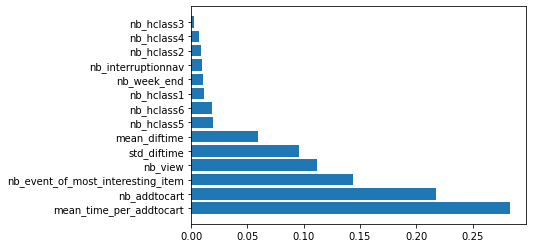

In [36]:
feat = pd.Series(rf_rus.feature_importances_, index=features.columns)
feat = feat.sort_values(ascending=False)
plt.barh(y = feat.index, width=feat)

In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [38]:
rf_balanced = BalancedRandomForestClassifier(n_estimators=600, max_features='sqrt', criterion='entropy')

rf_balanced.fit(X_train_scaled, y_train)

y_pred = rf_balanced.predict(X_test_scaled)

print(classification_report_imbalanced(y_test, y_pred))

pd.crosstab(y_test, y_pred)

                   pre       rec       spe        f1       geo       iba       sup

      False       1.00      0.97      0.96      0.98      0.96      0.93     78854
       True       0.46      0.96      0.97      0.62      0.96      0.93      2344

avg / total       0.98      0.97      0.96      0.97      0.96      0.93     81198



col_0,False,True
has_bought,,
False,76161,2693
True,94,2250


<BarContainer object of 14 artists>

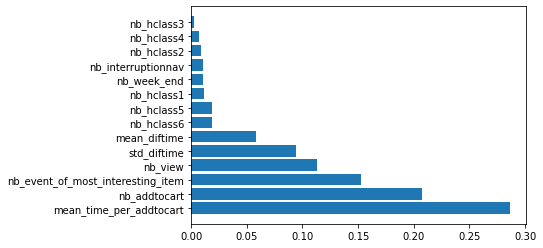

In [39]:
feat = pd.Series(rf_balanced.feature_importances_, index=features.columns)
feat = feat.sort_values(ascending=False)
plt.barh(y = feat.index, width=feat)

Les deux approches sont équivalentes en terme de performances: il y a une différence de 0.02 points sur le score de précision par rapport à la classe 1 en utilisant le modèle basé sur 'BalancedRandomForest'. 

## Seuil

A partir de ces modèles, il est possible de calculer les probabilités d'appartenir à chaque classe:
   - Soit pour affiner le rapport entre la précision et le rappel et trouver un équilibre satisfaisant pour l'utilisateur du modèle
   - Soit pour différencier les clients en fonction de leur probabilité d'acheter. Avec une probabilité très forte ou très faible (seuils à définir avec l'utilisateur du modèle), il n'est peut-etre pas nécessaire d'avoir une action car celle-ci aura peut d'impact.

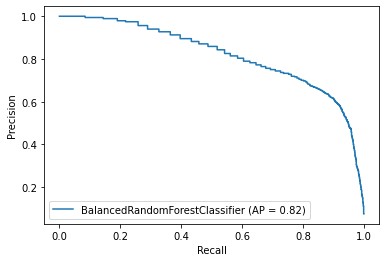

In [43]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(rf_balanced, X_test_scaled, y_test)

In [54]:
probs = rf_balanced.predict_proba(X_test_scaled)

In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [64]:
t=0.85
print(confusion_matrix(y_test, probs[:,1]>t))
print(precision_score(y_test, probs[:,1]>t))
print(recall_score(y_test, probs[:,1]>t))

[[77353  1501]
 [  196  2148]]
0.5886544258701014
0.9163822525597269
